In [10]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from math import log, sqrt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
mails=pd.read_csv('./spam.csv', encoding='latin-1')

In [3]:
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
mails.columns=['Label', 'Mail']
mails=mails[['Mail', 'Label']]
mails.head()

,Mail,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [5]:
mails['Label']=LabelEncoder().fit_transform(mails['Label'])

In [6]:
mails['length'] = mails['Mail'].apply(len)
mails.head()

,Mail,Label,length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


In [7]:
mails.groupby('Label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
Label                                                                 
0      4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
1       747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

In [8]:
total_mails=len(mails)
total_mails

5572

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AB89F64F08>,
      dtype=object)

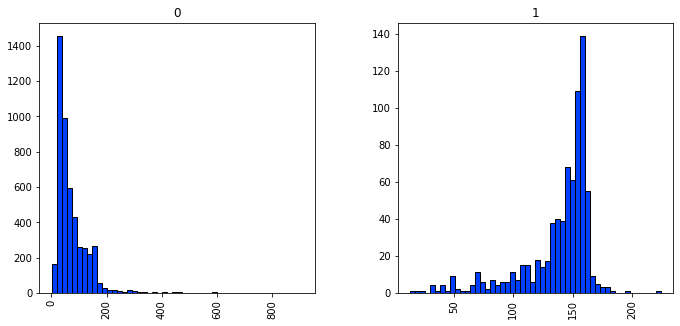

In [9]:
mlt.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
mails.hist(column='length', by='Label', bins=50,figsize=(11,5))

Above figure shows that higher number of words increase the chances of mail being a spam.

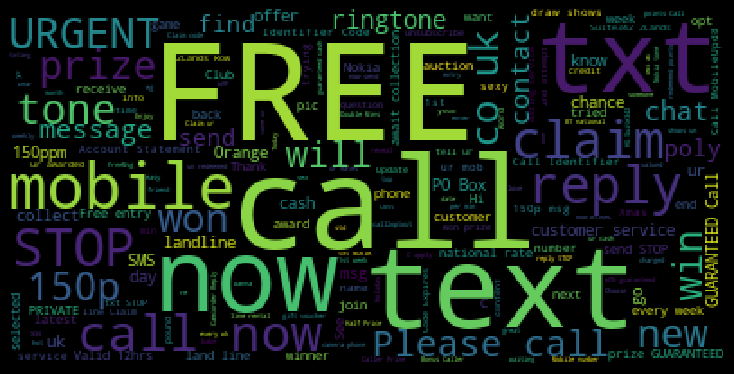

In [11]:
spam_words=' '.join(list(mails[mails['Label']==1]['Mail']))
spam_wc=WordCloud().generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [12]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [13]:
text_feat = mails['Mail'].copy().apply(text_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(features, mails['Label'], test_size=0.3, random_state=111)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [17]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [18]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}


In [19]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))

In [20]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [21]:
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df

C:\Users\premreeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.978469
KN,0.924641
NB,0.984450
DT,0.958732
LR,0.943182
RF,0.970096
AdaBoost,0.967105
BgC,0.967105
ETC,0.977273


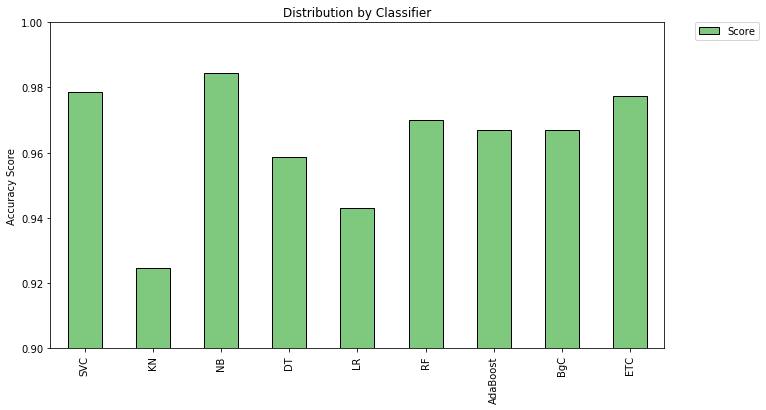

In [22]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words


In [24]:
text_feat = text_feat.apply(stemmer)

In [25]:
features = vectorizer.fit_transform(text_feat)

In [27]:
features_train, features_test, labels_train, labels_test = train_test_split(features, mails['Label'], test_size=0.3, random_state=111)

In [28]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))


In [29]:
df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

C:\Users\premreeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score,Score2
SVC,0.978469,0.978469
KN,0.924641,0.927632
NB,0.984450,0.985048
DT,0.958732,0.959928
LR,0.943182,0.946770
RF,0.970096,0.974880
AdaBoost,0.967105,0.970096
BgC,0.967105,0.968900
ETC,0.977273,0.977871


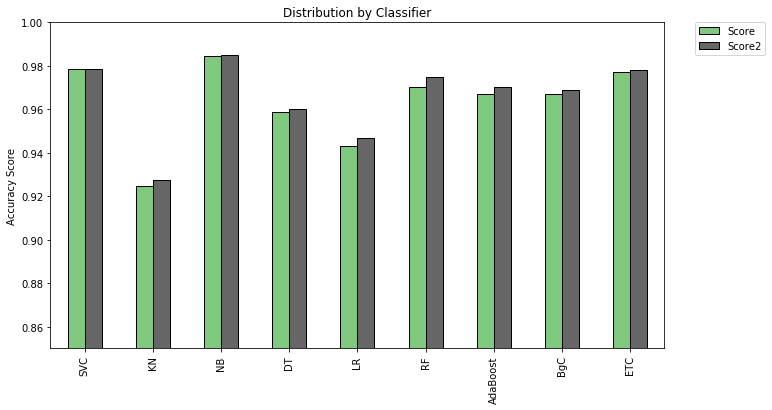

In [30]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [31]:
lf = mails['length'].as_matrix()
newfeat = np.hstack((features.todense(),lf[:, None]))

C:\Users\premreeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [33]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, mails['Label'], test_size=0.3, random_state=111)


In [34]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [35]:
df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score3'])
df = pd.concat([df,df3],axis=1)
df

C:\Users\premreeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score,Score2,Score3
SVC,0.978469,0.978469,0.861244
KN,0.924641,0.927632,0.881579
NB,0.984450,0.985048,0.982656
DT,0.958732,0.959928,0.957536
LR,0.943182,0.946770,0.954545
RF,0.970096,0.974880,0.975478
AdaBoost,0.967105,0.970096,0.961722
BgC,0.967105,0.968900,0.962321
ETC,0.977273,0.977871,0.975478


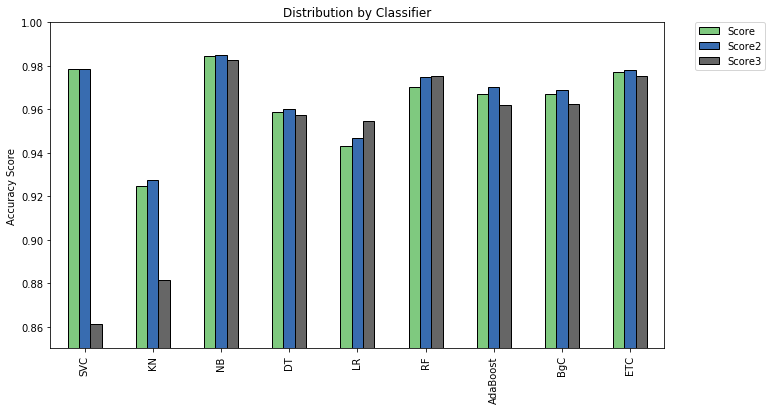

In [36]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [39]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(base_estimator=None,
                                                bootstrap=True,
                                                bootstrap_features=False,
                                                max_features=1.0,
                                                max_samples=1.0, n_estimators=9,
                                                n_jobs=None, oob_score=False,
                                                random_state=111, verbose=0,
                                                warm_start=False)),
                             ('ETC',
                              ExtraTreesClassifier(bootstrap=False,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',...


In [40]:
pred = eclf.predict(features_test)

In [41]:
print(accuracy_score(labels_test,pred))

0.979066985645933


# Conclusion

NaiveBayes Algorithm is the best algorithm in all we used.